In [2]:
%matplotlib inline
from momma_dragonn.data_loaders.hdf5_data_loader import MultimodalAtOnceDataLoader
data_loader = MultimodalAtOnceDataLoader(path_to_hdf5="Ctcf/valid_data.hdf5",
                                         bundle_x_and_y_in_generator=False,
                                         strip_enclosing_dictionary=True)
data = data_loader.get_data()

('Input modes', [u'sequence'])
('Output modes', [u'output'])
('num_to_load_for_eval is ', None, 'but num_items is', 17790, '- fixing')


In [6]:
!ls chr1_Ctcf/

Analyse Score Consistency.ipynb
config
different_data_subsets
inputs.gz
labels.gz
make_hdf5_yaml
model_files
model_weights.h5
prepSplits.sh
rc
runs_perf-metric-auROC.db
snapshots
splits
SummarisePerformanceAcrossNumFiltersChr1CTCF.ipynb
test_data.hdf5
train_data.hdf5
valid_data.hdf5


In [18]:

model_load_configs = [
    {"weights": "chr1_Ctcf/model_files/record_95_model_kbaIV_modelWeights.h5",
     "json": "chr1_Ctcf/model_files/record_95_model_kbaIV_modelJson.json",
     "descriptor": "chr1x2 rc-f_nbf-16_ws-f_str-20 seed-0"
    },
    {"weights": "chr1_Ctcf/rc/model_files/record_1_model_tdosQ_modelWeights.h5",
     "json": "chr1_Ctcf/rc/model_files/record_1_model_tdosQ_modelJson.json",
     "descriptor": "chr1CtcfAug rc-f_nbf-16_ws-f_str-20 seed-0"
    },
    {"weights": "chr1_Ctcf/model_files/record_99_model_0UAqF_modelWeights.h5",
     "json": "chr1_Ctcf/model_files/record_99_model_0UAqF_modelJson.json",
     "descriptor": "chr1x2 rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20 seed-0 "
    }
#    {'weights': "model_files/record_99_model_0UAqF_modelWeights.h5",
#     'json': "model_files/record_99_model_0UAqF_modelJson.json",
#     'descriptor': "rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20"},
#    {'weights': "model_files/record_95_model_kbaIV_modelWeights.h5",
#     'json': "model_files/record_95_model_kbaIV_modelJson.json",
#     'descriptor': "rc-f_nbf-16_ws-f_str-20"}
]


In [19]:
from deeplift.conversion import keras_conversion as kc
for model_load_config in model_load_configs:
    weights = model_load_config['weights']
    json = model_load_config['json']
    descriptor = model_load_config['descriptor']
    keras_model = kc.load_keras_model(weights=weights,
                                      json=json)
    model_load_config['model'] = keras_model

In [30]:
for model_load_config in model_load_configs:
    print("\n".join(str(x) for x in model_load_config['model'].get_config()))
    print("\n\n\n")

{'class_name': 'Convolution1D', 'config': {'batch_input_shape': (None, 1000, 4), 'W_constraint': None, 'b_constraint': None, 'name': u'convolution1d_1', 'activity_regularizer': None, 'trainable': True, 'filter_length': 15, 'init': 'glorot_uniform', 'bias': True, 'nb_filter': 16, 'input_dtype': u'float32', 'subsample_length': 1, 'border_mode': u'valid', 'input_dim': None, 'b_regularizer': None, 'W_regularizer': None, 'activation': 'linear', 'input_length': None}}
{'class_name': 'BatchNormalization', 'config': {'gamma_regularizer': None, 'name': u'batchnormalization_1', 'epsilon': 0.001, 'trainable': True, 'mode': 0, 'beta_regularizer': None, 'momentum': 0.99, 'axis': -1}}
{'class_name': 'Activation', 'config': {'activation': 'relu', 'trainable': True, 'name': u'activation_1'}}
{'class_name': 'Convolution1D', 'config': {'W_constraint': None, 'b_constraint': None, 'name': u'convolution1d_2', 'activity_regularizer': None, 'trainable': True, 'filter_length': 14, 'init': 'glorot_uniform', 'b

In [20]:
import numpy as np
import matplotlib.pyplot as plt
nregions = 10000

X = np.array(data.X[:nregions])
Y = np.array(data.Y[:nregions])

chr1x2 rc-f_nbf-16_ws-f_str-20 seed-0
0.9735
0.9146


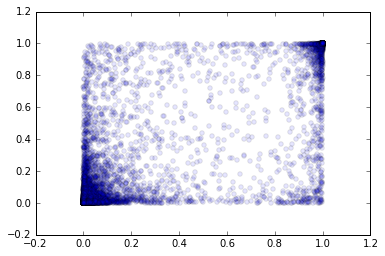

chr1CtcfAug rc-f_nbf-16_ws-f_str-20 seed-0
0.8953
0.8932


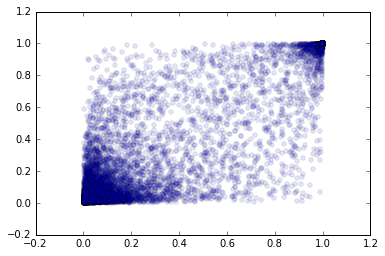

chr1x2 rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20 seed-0 
0.9742
0.9742


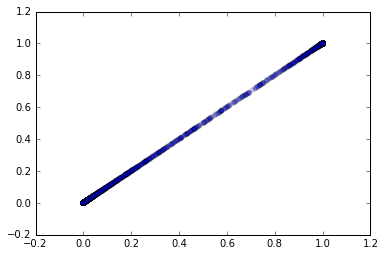

In [21]:
for model_load_config in model_load_configs:
    print(model_load_config['descriptor'])
    keras_model = model_load_config['model']
    fwd_predictions = keras_model.predict(X)
    rev_predictions = keras_model.predict(X[:,::-1,::-1])
    
    fwd_prediction_acc = np.sum((fwd_predictions > 0.5)*1 == Y)/float(nregions)
    rev_prediction_acc = np.sum((rev_predictions > 0.5)*1 == Y)/float(nregions)
    
    print(fwd_prediction_acc)
    print(rev_prediction_acc)
    
    plt.figure()
    plt.scatter(fwd_predictions, rev_predictions, alpha=0.1)
    plt.show()

In [34]:
#load the database records to show difference in perf
records_infos = [
    {'database_path': "chr1_Ctcf/runs_perf-metric-auROC.db",
     'descriptor': "chr1x2 rc-f_nbf-16_ws-f_str-20",
     'name': "normal model"},
    {'database_path': "chr1_Ctcf/rc/runs_perf-metric-auROC.db",
     'descriptor': "chr1CtcfAug rc-f_nbf-16_ws-f_str-20",
     'name': "normal model, rc data aug"},
    {'database_path': "chr1_Ctcf/runs_perf-metric-auROC.db",
     'descriptor': "rc-t_nbf-16_ws-t_symws-f_ircws-t_str-20",
     'name': "rc layers model"}, 
]

In [149]:
import json
from collections import OrderedDict
grouped_records = OrderedDict()
for records_info in records_infos:
    db_records = json.loads(open(records_info['database_path']).read())['records']
    filtered_records = []
    unique_messages = set()
    for record in db_records:
        message = record['message']
        if records_info['descriptor'] in message:
            if message not in unique_messages: #avoid double-counting runs
                filtered_records.append(record)
                unique_messages.add(message)
    grouped_records[records_info['name']] = filtered_records

In [48]:
auroc_per_group = OrderedDict([(key, [x['best_valid_perf_info']['valid_all_stats']['mean_auROC'] for x in grouped_records[key]]) for key in grouped_records])
auprc_per_group = OrderedDict([(key, [x['best_valid_perf_info']['valid_all_stats']['mean_auPRC'] for x in grouped_records[key]]) for key in grouped_records])

In [180]:
#R has the exact wilcoxon test implemented. So, paste these arrays into R to test p-value. Use one-sided test
for group, groupname in [(auroc_per_group,'auroc'), (auprc_per_group,'auprc')]:
    for key in auroc_per_group:
        keyclean = key.replace(" ","_").replace(",","")+"_"+groupname
        print keyclean, "<-","c("+",".join(str(x) for x in group[key])+")"
    for key1, key2 in zip(auroc_per_group.keys()[:-1], group.keys()[1:]):
        key1 = key1.replace(" ","_").replace(",","")+"_"+groupname
        key2 = key2.replace(" ","_").replace(",","")+"_"+groupname
        print("wilcox.test("+key1+", "+key2+", alternative=\"less\")")

normal_model_auroc <- c(0.959226875615,0.957094610766,0.956650182423,0.956269198889,0.956065294426,0.9557605784,0.955668734857,0.954360210215,0.954312990441,0.953215784613)
normal_model_rc_data_aug_auroc <- c(0.9663002247,0.965439393076,0.965006312424,0.964429763113,0.964148961808,0.963730139522,0.96356928549,0.963101611093,0.962905061979,0.96069470062)
rc_layers_model_auroc <- c(0.969571290472,0.968523664423,0.968120418172,0.968077643075,0.967809271132,0.96737619048,0.967255672873,0.967203536421,0.966727090671,0.966463753405)
wilcox.test(normal_model_auroc, normal_model_rc_data_aug_auroc, alternative="less")
wilcox.test(normal_model_rc_data_aug_auroc, rc_layers_model_auroc, alternative="less")
normal_model_auprc <- c(0.878349327307,0.879318252484,0.877218108927,0.878305718882,0.872747959179,0.869819747037,0.875038684411,0.870063555049,0.873396883183,0.870040395666)
normal_model_rc_data_aug_auprc <- c(0.900680652116,0.891827005547,0.897332124731,0.895723101716,0.893760125683,0.89336359

(0.17499999999999999, 0.96243254538260825)
(1.175, 0.96621285311236127)


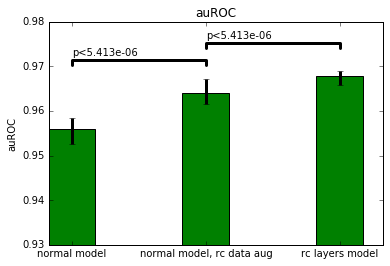

(0.17499999999999999, 0.88949460904451461)
(1.175, 0.90252806088757576)


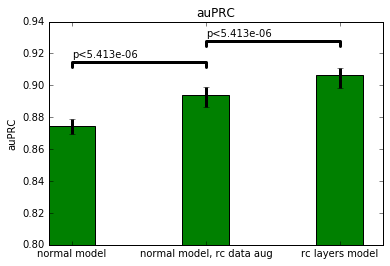

In [185]:
def label_diff(i,j,text,X,Y,yrange):
    x = (X[i]+X[j])/2
    y = 1.0*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    y = y - 0.03*yrange
    
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':35,'shrinkB':35,'lw':3}
    ax.annotate(text, xy=(X[i],y+yrange*0.2), zorder=10)
    print((X[i],y+0.0))
    ax.annotate('', xy=(X[i],y+0.0), xytext=(X[j],y), arrowprops=props)

for group_stats, stats_name, ymin, ymax in [(auroc_per_group, 'auROC', 0.93, 0.98), (auprc_per_group, 'auPRC', 0.8, 0.94)]:

    N = 3
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig, ax = plt.subplots()

    X = ind+width/2
    
    all_rects = []
    
    
    keys = list(group_stats.keys())
    
    for series_idx, (series, color) in enumerate([(keys, 'g')]):
        means = np.array([np.mean(group_stats[x]) for x in series])
        upper_error = np.array([np.max(group_stats[x]) for x in series]) - means
        lower_error = np.abs(np.array([np.min(group_stats[x]) for x in series]) - means)
        rects = ax.bar(ind + width*series_idx, means, width, color=color, yerr=[upper_error, lower_error], ecolor='k', error_kw={'elinewidth':3})
        all_rects.append(rects)
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel(stats_name)
    ax.set_ylim(ymin,ymax)
    ax.set_title(stats_name)
    ax.set_xticks(ind + width / 2.0)
    ax.set_xticklabels(group_stats.keys())
#    ax.legend((all_rects[0][0]), ('without-rc', 'with-rc'), loc=0)

    label_diff(0,1,'p<5.413e-06',X,means,ymax-ymin)
    label_diff(1,2,'p<5.413e-06',X,means,ymax-ymin)
    
    plt.show()


In [ ]:
import theano
import keras.backend as K
layer9_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[9].output, allow_input_downcast=True)
layer10_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[10].output, allow_input_downcast=True)
layerm2_out = theano.function([keras_model.input, K.learning_phase()],
                             keras_model.layers[-2].output, allow_input_downcast=True)

In [12]:
import numpy as np
random_input = np.random.random((1,1000,4))

In [13]:
print(np.max(np.abs(layer9_out(random_input, False) - layer9_out(random_input[:, ::-1, ::-1], False)[:,::-1,::-1])))
print(layer10_out(random_input, False))
print(layer10_out(random_input[:,::-1,::-1], False))
print(layerm2_out(random_input, False))
print(layerm2_out(random_input[:,::-1,::-1], False))

2.6226e-06
[[ -2.51437783e-01   4.19698358e-01   8.48584414e-01  -5.57352304e-01
   -8.74572434e-04  -1.23056024e-03  -9.86010909e-01  -4.20085400e-01
    1.15228549e-01  -2.26033151e-01   8.87029395e-02   1.21177442e-01
   -3.24154906e-02   1.09678936e+00  -8.52027237e-02   4.34186101e-01
    3.25265288e-01  -5.27580976e-02   1.03787553e+00   1.42582193e-01
   -1.58223901e-02   3.08232903e-01  -1.06000900e-01   1.22726616e-02
   -2.55050123e-01  -6.84527159e-01   1.98173150e-01  -1.69384211e-01
   -1.59774750e-01   1.18553293e+00   1.51197106e-01  -2.89092243e-01]]
[[ -2.89092064e-01   1.51196986e-01   1.18553269e+00  -1.59774959e-01
   -1.69384241e-01   1.98173046e-01  -6.84527516e-01  -2.55050033e-01
    1.22724734e-02  -1.06000841e-01   3.08233023e-01  -1.58224478e-02
    1.42582163e-01   1.03787529e+00  -5.27581871e-02   3.25265676e-01
    4.34185922e-01  -8.52028951e-02   1.09678912e+00  -3.24154310e-02
    1.21177338e-01   8.87030512e-02  -2.26033270e-01   1.15228646e-01
   -4.2

In [23]:
import numpy as np
random_inp = np.random.random((10,1000,4))
print(keras_model.predict(random_inp))
print(keras_model.predict(random_inp[:, ::-1, ::-1]))
print(keras_model.predict(random_inp) - keras_model.predict(random_inp[:, ::-1, ::-1]))

[[ 0.07186917]
 [ 0.07434497]
 [ 0.12864782]
 [ 0.18770845]
 [ 0.04313384]
 [ 0.0209079 ]
 [ 0.02083969]
 [ 0.04040418]
 [ 0.03760781]
 [ 0.01761588]]
[[ 0.21423988]
 [ 0.05645425]
 [ 0.18132485]
 [ 0.07592847]
 [ 0.05251423]
 [ 0.05046884]
 [ 0.11245374]
 [ 0.02317481]
 [ 0.06928993]
 [ 0.04388957]]
[[-0.1423707 ]
 [ 0.01789072]
 [-0.05267704]
 [ 0.11177998]
 [-0.00938039]
 [-0.02956094]
 [-0.09161405]
 [ 0.01722937]
 [-0.03168212]
 [-0.0262737 ]]


In [22]:
print(descriptor)

rc-f_nbf-16_ws-f_str-20


In [9]:
#compute grad*input importance scores
import theano
from keras import backend as K
import numpy as np
=

In [11]:
fwd_scores = score_func(random_inp, False)

In [12]:
rev_scores = score_func(random_inp[:,::-1,::-1], False)

In [13]:
fwd_scores

array([[[  2.88720687e-05,   2.10542168e-06,  -3.05712719e-07,
           5.01426661e-06],
        [  6.44317652e-06,  -6.10106716e-06,   3.29393166e-05,
          -5.93701917e-06],
        [ -1.19300901e-05,   6.60085608e-05,  -3.63180555e-05,
          -3.47935793e-05],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          -0.00000000e+00],
        [ -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
          -0.00000000e+00]],

       [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          -0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [ -9.30333819e-06,  -2.39654940e-05,  -3.66509386e-05,
           8.79684209e-06],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+0

In [14]:
rev_scores

array([[[ -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
          -0.00000000e+00],
        [ -1.49720193e-06,  -1.38762531e-06,   4.74566969e-06,
           1.83765845e-05],
        ..., 
        [ -2.30729281e-05,  -1.64095363e-04,   2.85617817e-04,
           7.44929357e-05],
        [  2.42459380e-05,   4.88165322e-05,  -8.79188661e-06,
          -1.63304653e-04],
        [  2.78936315e-06,   2.37722854e-06,  -2.99817116e-05,
          -1.83410632e-04]],

       [[  0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        ..., 
        [  4.09363629e-05,  -2.10790250e-05,  -8.65714357e-05,
          -5.59211855e-05],
        [  3.92407456e-06,  -5.50303633e-05,   8.22958304e-0